In [18]:
import ROOT
ROOT.gStyle.SetOptFit(1)

import lmfit


#add the dev version of aare
# import sys; sys.path.append('/home/l_msdetect/erik/aare/build')
from helpers import nb_aare_version
nb_aare_version()

#Our normal python imports
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import boost_histogram as bh
import seaborn as sns
import time
import timeit
from rich.jupyter import print

from aare import fit_gaus, gaus

def gauss_py(x, a0, mu, sigma):
    return gaus(x, (a0,mu,sigma))

n_iter = 1000

Example run on: **2025-02-19 12:33** with aare: **2025.2.18**

## Generate some data

In [2]:
#Create some sample data
n_samples = 1000
mu = 7
sigma = 1.3
n_bins = 60
xmin = 0
xmax = 14

values = np.random.normal(loc = mu, scale = sigma, size = n_samples)
hist = bh.Histogram(bh.axis.Regular(n_bins, xmin, xmax))
hist.fill(values)
x = hist.axes[0].edges[:-1]
x = hist.axes.centers[0]
y = hist.values()

y_err = np.sqrt(y)
y_err[y_err<1] = 1

rows = 1024
cols = 1024

y_data = np.zeros((rows,cols, y.size))
for row in range(y_data.shape[0]):
    for col in range(y_data.shape[1]):
        y_data[row, col, :] = y

y_data_err = np.zeros((rows,cols, y.size))
for row in range(y_data.shape[0]):
    for col in range(y_data.shape[1]):
        y_data_err[row, col, :] = y_err


### aare

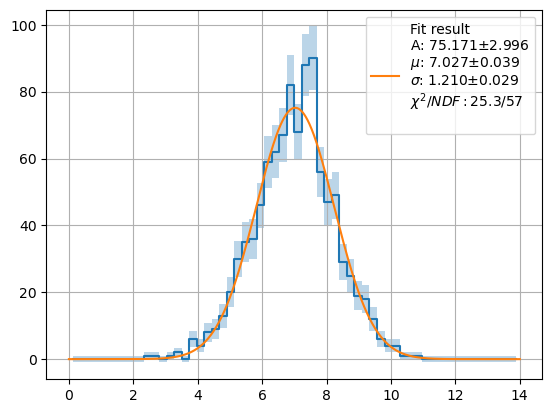

In [3]:
#Estimate errors as square root of the number of samples
#in a single bin. Add 1 to avoid 0s in the error estimate
#Lower errors generally narrows the fit. 
res = fit_gaus(x,y, y_err)
par = res['par']
err = res['par_err']
chi2 = res['chi2']
Ndf = res['Ndf']
xx = np.linspace(0,14,1000)
yy = gaus(xx, par)
fig, ax = plt.subplots()
ax.step(x, y, where="mid");

ax.fill_between(x, y-y_err, y+y_err, step = 'mid', alpha = 0.3)

label = fr"""Fit result
A: {par[0]:.3f}$\pm{err[0]:.3f}$
$\mu$: {par[1]:.3f}$\pm{err[1]:.3f}$
$\sigma$: {par[2]:.3f}$\pm{err[2]:.3f}$
$\chi^2/NDF: {chi2:.1f}/{Ndf}$
"""

ax.plot(xx,yy, label = label)
ax.legend()
ax.grid();

In [4]:
res

{'par': array([75.17073529,  7.02680359,  1.20982226]),
 'par_err': array([2.99624405, 0.03917688, 0.02928822]),
 'chi2': 25.265306120520698,
 'Ndf': 57}

In [5]:
a = timeit.timeit('fit_gaus(x,y, y_err)', number = n_iter, globals = globals())
t_aare = a/n_iter*1e6
print(f'aare: {t_aare:.2f} us / per fit')
aare_results = (par, err, t_aare)

aare: 35.58 us / per fit

## PyROOT histogram

60

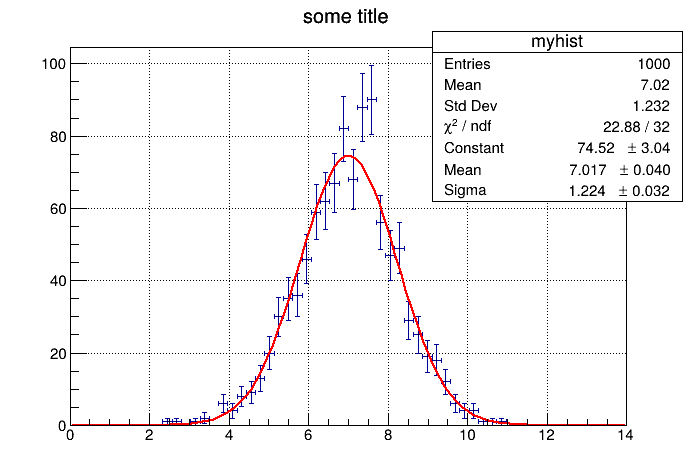

In [6]:
c = ROOT.TCanvas('c1')
h = ROOT.TH1D('myhist', 'some title', n_bins, xmin, xmax)
# h.SetBinErrorOption(ROOT.TH1.kPoisson)
for v in values:
    h.Fill(v)

# for it in x:
#     h.Fill(it)

fit = h.Fit('gaus', 'SQ')

c.Draw()
c.SetGrid()
h.Draw("E1")


par = tuple(fit.Get().Parameter(i) for i in range(3))
err = tuple(fit.Get().ParError(i) for i in range(3))

print(h.GetNbinsX())

In [7]:
#ROOT single fit round trip time
#NOTE! ROOT ignores empty bins for the fit
a = timeit.timeit("h.Fit('gaus', 'SQ')", number = n_iter, globals = globals())
t_root = a/n_iter*1e6
print(f'ROOT: {t_root:.2f} us / per fit')
root_results = (par, err, t_root)

ROOT: 109.52 us / per fit

## PyROOT TGraphErrors

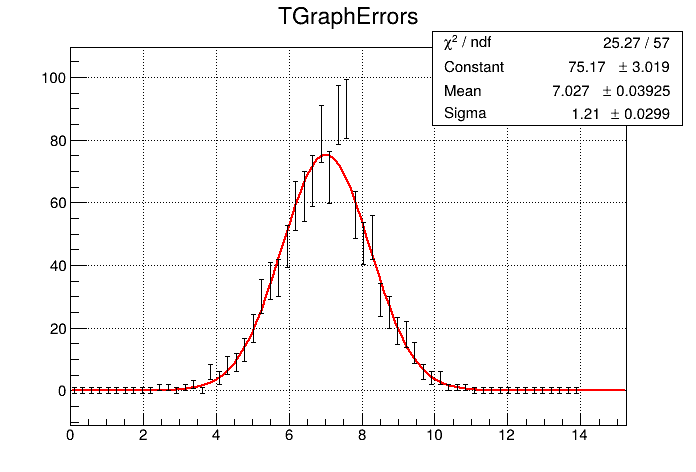

In [8]:
x_err = np.zeros(x.size)
c = ROOT.TCanvas('c2')
g = ROOT.TGraphErrors(n_bins, x, y, x_err, y_err)
g.SetTitle("TGraphErrors")

func = ROOT.TF1('mygaus', 'gaus')
fit = g.Fit(func, 'SQ')

c.Draw()
c.SetGrid()
g.Draw('AP')

In [9]:
# #ROOT single fit round trip time
code = """
func = ROOT.TF1('mygaus', 'gaus')
g.Fit('gaus', 'SQ')
"""
a = timeit.timeit(code, number = n_iter, globals = globals())
t_rootg = a/n_iter*1e6
print(f'ROOT: {t_rootg:.2f} us / per fit')
# root_results = (par, err, t_root)

ROOT: 234.94 us / per fit

## Python lmfit

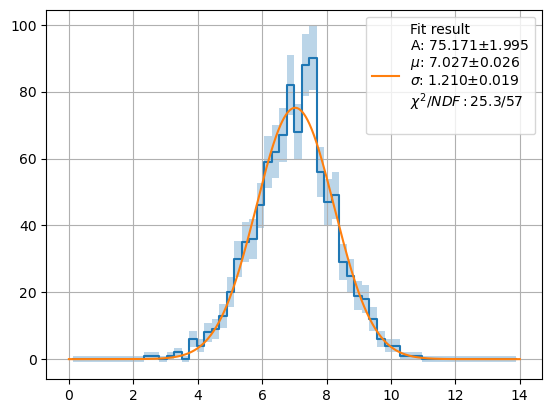

In [10]:

fit_model = lmfit.Model(gauss_py)
results = fit_model.fit(y, x=x, weights=1/y_err, a0=np.max(y), mu=x[np.where(y == np.max(y))[0][0]], sigma=2)


par = np.array([results.params[name].value for name in results.params])
err = np.array([results.params[name].stderr for name in results.params])
chi2 = results.chisqr
ndf = results.nfree
r2 = results.rsquared

yy = gauss_py(xx, *par)
fig, ax = plt.subplots()
ax.step(x, y, where="mid");
ax.fill_between(x, y-y_err, y+y_err, step = 'mid', alpha = 0.3)

label = fr"""Fit result
A: {par[0]:.3f}$\pm{err[0]:.3f}$
$\mu$: {par[1]:.3f}$\pm{err[1]:.3f}$
$\sigma$: {par[2]:.3f}$\pm{err[2]:.3f}$
$\chi^2/NDF: {chi2:.1f}/{Ndf}$
"""

ax.plot(xx,yy, label = label)
ax.legend()
ax.grid();


In [11]:
code ="""
fit_model = lmfit.Model(gauss_py)
results = fit_model.fit(y, x=x, weights=1/y_err, a0=np.max(y), mu=x[np.where(y == np.max(y))[0][0]], sigma=2)
"""
a = timeit.timeit(code, number = n_iter, globals = globals())
t_lmfit = a/n_iter*1e6
print(f'lmfit: {t_lmfit:.2f} us / per fit')
lmfit_results = (par, err, t_lmfit)

lmfit: 1808.05 us / per fit

## iminuit

In [12]:
from iminuit import Minuit
from iminuit.cost import LeastSquares
import iminuit

least_squares = LeastSquares(x, y, y_err, gauss_py)

m = Minuit(least_squares, a0=np.max(y), mu=x[np.where(y == np.max(y))[0][0]], sigma=2)  # starting values for α and β

m.migrad()  # finds minimum of least_squares function
m.hesse()  # accurately computes uncertainties

par = tuple(m.values.to_dict().values())
err = tuple(m.errors.to_dict().values())

In [13]:
m.errors

<ErrorView a0=3.0183466873227265 mu=0.03924686718816408 sigma=0.029896615777412625>

In [14]:
code = """
least_squares = LeastSquares(x, y, y_err, gauss_py)
m = Minuit(least_squares, a0=np.max(y), mu=x[np.where(y == np.max(y))[0][0]], sigma=2)  # starting values for α and β
m.migrad() 
m.hesse()
"""
# n_iter = 1000
a = timeit.timeit(code, number = n_iter, globals = globals())
t_minuit = a/n_iter*1e6
m.hesse()
print(f'lmfit: {t_minuit:.2f} us / per fit')
iminuit_results = (par, err, t_minuit)

lmfit: 1136.37 us / per fit

In [15]:
from rich.table import Table
table = Table(title="Fit Results")

table.add_column("Parameter", justify="left", style="cyan", no_wrap=True)
table.add_column("aare", justify='right',style="magenta")
table.add_column("PyROOT", justify="right", style="green")
table.add_column("lmfit", justify="right", style="blue")
table.add_column("iminuit", justify="right", style="red")

table.add_row("A", 
f"""{aare_results[0][0]:.3f}\u00B1{aare_results[1][0]:.3f}""", 
f"""{root_results[0][0]:.3f}\u00B1{root_results[1][0]:.3f}""",
f"""{lmfit_results[0][0]:.3f}\u00B1{lmfit_results[1][0]:.3f}""",
f"""{iminuit_results[0][0]:.3f}\u00B1{iminuit_results[1][0]:.3f}""")

table.add_row("mu", 
f"""{aare_results[0][1]:.3f}\u00B1{aare_results[1][1]:.3f}""", 
f"""{root_results[0][1]:.3f}\u00B1{root_results[1][1]:.3f}""",
f"""{lmfit_results[0][1]:.3f}\u00B1{lmfit_results[1][1]:.3f}""",
f"""{iminuit_results[0][1]:.3f}\u00B1{iminuit_results[1][1]:.3f}"""
)
table.add_row("sigma", 
f"""{aare_results[0][2]:.3f}\u00B1{aare_results[1][2]:.3f}""", 
f"""{root_results[0][2]:.3f}\u00B1{root_results[1][2]:.3f}""",
f"""{lmfit_results[0][2]:.3f}\u00B1{lmfit_results[1][2]:.3f}""",      
f"""{iminuit_results[0][2]:.3f}\u00B1{iminuit_results[1][2]:.3f}"""
)

table.add_row("time (us)", 
f"""{aare_results[2]:.3f}""", 
f"""{root_results[2]:.3f}""",
f"""{lmfit_results[2]:.3f}""",  
f"""{iminuit_results[2]:.3f}"""
)

print(table)

                               Fit Results                               
┏━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Parameter ┃         aare ┃       PyROOT ┃        lmfit ┃      iminuit ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ A         │ 75.171±2.996 │ 74.519±3.045 │ 75.171±1.995 │ 75.171±3.018 │
│ mu        │  7.027±0.039 │  7.017±0.040 │  7.027±0.026 │  7.027±0.039 │
│ sigma     │  1.210±0.029 │  1.224±0.032 │  1.210±0.019 │  1.210±0.030 │
│ time (us) │       35.577 │      109.517 │     1808.045 │     1136.371 │
└───────────┴──────────────┴──────────────┴──────────────┴──────────────┘

In [16]:
print(f'{y_data.shape=}')
n_fits = y_data.shape[0]*y_data.shape[1]
t0 = time.perf_counter()

res = fit_gaus(x,y_data, y_data_err, n_threads = 32)

# res = fit_gaus(x,y_data, n_threads = 32)
t_elapsed  = time.perf_counter()-t0
print(f'Fitting took: {t_elapsed:.3f}s {t_elapsed/n_fits*1e6:.3f}us/fit')

y_data.shape=(1024, 1024, 60)

Fitting took: 1.064s 1.015us/fit

In [17]:
# res[:,:,2]